In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline


In [2]:
#Upload the Dataset
from google.colab import files
uploaded = files.upload()

Saving Clean_data_1.csv to Clean_data_1.csv


In [3]:
# Dataset is now stored in a Pandas Dataframe
import io
data = pd.read_csv(io.BytesIO(uploaded['Clean_data_1.csv']))

In [4]:
data.head()

,Unnamed: 0,Hotel_id,Hotel,Address,City,Title,Users,Reviews,Rating,User_id,Sentiment,Label,Text_Clean,lemmatized,polarity,token,review_length
0,0,0,La Quinta,5820 Walden Rd,Beaumont,This hotel is a dump! Upon ch...,margierodriguez.mcqueen,This hotel is a dump! Upon checking in was tol...,1,15400,Negative,0,this hotel is a dump upon checking in was told...,hotel dump check tell place book folk run isaa...,0.188788,"['this', 'hotel', 'is', 'a', 'dump', 'upon', '...",209
1,1,1,The Point,Po Box 1327,Saranac Lake,Great family time,motomomMaryland,The point is possibly one of our favorite rest...,5,15740,Positive,1,the point is possibly one of our favorite rest...,point possibly favorite restaurant child age f...,0.350000,"['the', 'point', 'is', 'possibly', 'one', 'of'...",60
2,2,1,The Point,Po Box 1327,Saranac Lake,Throw back to the Gatsby Era - don't miss The ...,ellen00007,From the minute you arrive until the minute yo...,5,13760,Positive,1,from the minute you arrive until the minute yo...,minute arrive minute sadly leave point treat p...,0.233333,"['from', 'the', 'minute', 'you', 'arrive', 'un...",67
3,3,1,The Point,Po Box 1327,Saranac Lake,The Point of it all,Szerzek,That is the name on one of their boats. And th...,5,11027,Positive,1,that is the name on one of their boats and the...,boat essence philosophy get point right warm c...,0.372857,"['that', 'is', 'the', 'name', 'on', 'one', 'of...",66
4,4,1,The Point,Po Box 1327,Saranac Lake,The most amazing week end!,Sarahbnyc83,I was lucky enough to spend 2 nights at The Po...,5,10306,Positive,1,i was lucky enough to spend nights at the poin...,lucky spend night point year february dream pl...,-0.043434,"['i', 'was', 'lucky', 'enough', 'to', 'spend',...",65


In [5]:
# Checking for missing values
pd.isnull(data).any()

Unnamed: 0       False
Hotel_id         False
Hotel            False
Address          False
City             False
Title            False
Users            False
Reviews          False
Rating           False
User_id          False
Sentiment        False
Label            False
Text_Clean        True
lemmatized        True
polarity         False
token            False
review_length    False
dtype: bool

In [6]:
data = data.dropna()
data = data.reset_index(drop=True)
print('Shape of dataset ',data.shape)
print(data.columns)
print('No. of unique classes',len(set(data['Sentiment'])))

Shape of dataset  (10002, 17)
Index(['Unnamed: 0', 'Hotel_id', 'Hotel', 'Address', 'City', 'Title', 'Users',
       'Reviews', 'Rating', 'User_id', 'Sentiment', 'Label', 'Text_Clean',
       'lemmatized', 'polarity', 'token', 'review_length'],
      dtype='object')
No. of unique classes 2


In [7]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string

In [8]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.25

In [9]:
macronum=sorted(set(data['Label']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

data['Label']=data['Label'].apply(fun)

In [10]:
texts = []
labels = []


for idx in range(data.Text_Clean.shape[0]):
    text = BeautifulSoup(data.Text_Clean[idx])
    texts.append(clean_str(str(text.get_text().encode())))

for idx in data['Label']:
    labels.append(idx)

In [11]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 23725


In [12]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (10002, 1000)
Shape of Label Tensor: (10002, 2)


In [13]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-10-15 12:09:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-15 12:09:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-15 12:09:11--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [14]:
!unzip glove*.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [15]:
!ls
!pwd

Clean_data_1.csv   glove.6B.200d.txt  glove.6B.50d.txt	sample_data
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
/content


In [16]:
embeddings_index = {}
f = open('glove.6B.300d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 300d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 300d.


In [17]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [18]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [19]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(len(macronum), activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()

Bidirectional LSTM
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 300)         7117800   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 2)                 402       
Total params: 7,439,002
Trainable params: 7,439,002
Non-trainable params: 0
_________________________________________________________________


In [20]:
cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=7, batch_size=32,callbacks=[cp])

Epoch 1/7
235/235 [==============================] - ETA: 0s - loss: 0.4711 - acc: 0.7929
Epoch 00001: val_acc improved from -inf to 0.83840, saving model to model_rnn.hdf5
235/235 [==============================] - 793s 3s/step - loss: 0.4711 - acc: 0.7929 - val_loss: 0.3933 - val_acc: 0.8384
Epoch 2/7
235/235 [==============================] - ETA: 0s - loss: 0.3578 - acc: 0.8491
Epoch 00002: val_acc did not improve from 0.83840
235/235 [==============================] - 788s 3s/step - loss: 0.3578 - acc: 0.8491 - val_loss: 0.4426 - val_acc: 0.8120
Epoch 3/7
235/235 [==============================] - ETA: 0s - loss: 0.2869 - acc: 0.8846
Epoch 00003: val_acc improved from 0.83840 to 0.86480, saving model to model_rnn.hdf5
235/235 [==============================] - 790s 3s/step - loss: 0.2869 - acc: 0.8846 - val_loss: 0.3309 - val_acc: 0.8648
Epoch 4/7
235/235 [==============================] - ETA: 0s - loss: 0.2350 - acc: 0.9094
Epoch 00004: val_acc improved from 0.86480 to 0.86720, 

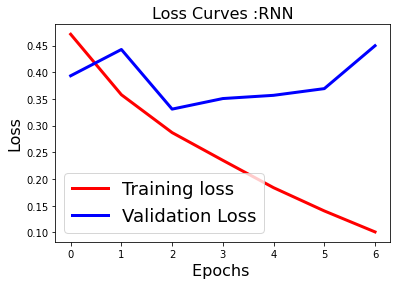

In [21]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn.png')
plt.show()

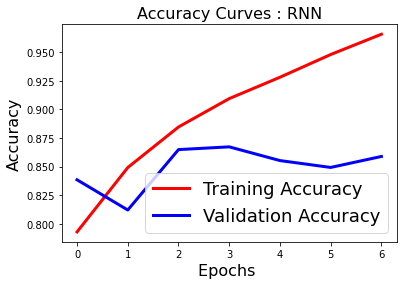

In [22]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn.png')
plt.show()

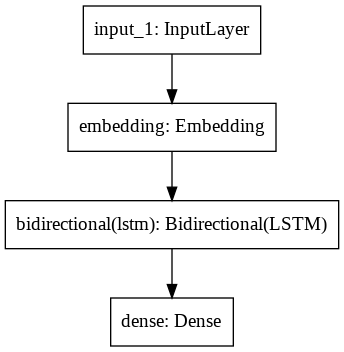

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='rnn_model.png')